In [2]:
# Cell 1: Imports + GPU check + dataset path

import os
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

print("TensorFlow version:", tf.__version__)

# List GPUs to confirm WSL + CUDA is working
gpus = tf.config.list_physical_devices("GPU")
print("GPUs available:", gpus)

# (Optional) enable memory growth so TF doesn't grab all VRAM at once
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print("Could not set memory growth for", gpu, "->", e)

# Path to your dataset in WSL (D: -> /mnt/d)
DATA_DIR = "/mnt/d/ai-baby-care/dataset"
data_path = pathlib.Path(DATA_DIR)
print("Dataset path:", data_path)

# Quick sanity check: list subfolders (should show your emotion classes or train/val folders)
print("Subdirectories:", [p.name for p in data_path.iterdir() if p.is_dir()])

TensorFlow version: 2.20.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Dataset path: /mnt/d/ai-baby-care/dataset
Subdirectories: ['Angry', 'Cry', 'Laugh', 'Normal']


In [4]:
#Cell 2 (UPDATED): Load datasets with safer memory settings

import tensorflow as tf

# Use slightly smaller images to reduce RAM/VRAM usage
IMG_SIZE = (256, 256)     # was (300, 300)
BATCH_SIZE = 16           # reduce if you still get OOM (try 8)

SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,               # /mnt/d/ai-baby-care/dataset
    labels="inferred",
    label_mode="int",
    validation_split=0.2,    # 80% train, 20% val
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)

# Optimize pipeline with smaller shuffle buffer to avoid huge pinned host allocations
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(128).prefetch(AUTOTUNE)   # was 1000 → 128
val_ds = val_ds.prefetch(AUTOTUNE)

Found 26143 files belonging to 4 classes.
Using 20915 files for training.
Found 26143 files belonging to 4 classes.
Using 5228 files for validation.
Classes: ['Angry', 'Cry', 'Laugh', 'Normal']
Number of classes: 4


In [5]:
# Cell 3: Data augmentation and EfficientNetB3 transfer learning model

from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

# 1) Data augmentation pipeline
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.05, 0.05),
    ],
    name="data_augmentation",
)

# 2) Input layer
inputs = layers.Input(shape=IMG_SIZE + (3,), name="input_image")

# 3) Apply data augmentation only in training
x = data_augmentation(inputs)

# 4) Preprocess for EfficientNetB3
x = preprocess_input(x)

# 5) EfficientNetB3 base model (ImageNet pretrained, no top)
base_model = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_tensor=x,
    pooling="avg",
)

# Freeze base model for initial training phase
base_model.trainable = False

# 6) Classification head
x = layers.BatchNormalization()(base_model.output)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

model = Model(inputs=inputs, outputs=outputs, name="EfficientNetB3_emotion")

# 7) Compile model (Phase 1: frozen base)
initial_lr = 1e-3
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=initial_lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy",
             keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3_acc")]
)

model.summary()


Model: "EfficientNetB3_emotion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 256, 256,  │          0 │ input_image[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati

 Total params: 11,185,203 (42.67 MB)

 Trainable params: 398,084 (1.52 MB)

 Non-trainable params: 10,787,119 (41.15 MB)

In [7]:
# Cell 4 (UPDATED): Callbacks + Phase 1 training (frozen EfficientNetB3, .keras saving)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Directory to save best model
save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

# Save best phase-1 model in native Keras format
checkpoint_path = os.path.join(save_dir, "best_model_phase1.keras")

callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=4,              # reduce patience a bit to save time
        restore_best_weights=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),

    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
        # no need to specify format; ".keras" triggers native format
    ),
]

# You don't need 20 epochs for frozen head training.
EPOCHS_PHASE1 = 8

history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks,
    verbose=1
)

# Also save the final (current) phase-1 model explicitly if you want
final_phase1_path = os.path.join(save_dir, "final_model_phase1.keras")
model.save(final_phase1_path)
print("Saved phase-1 best model to:", checkpoint_path)
print("Saved phase-1 final model to:", final_phase1_path)

Epoch 1/8


2025-11-22 10:37:56.260129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 54 of 128
2025-11-22 10:38:06.147266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 121 of 128
2025-11-22 10:38:06.703870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5123 - loss: 1.0629 - top3_acc: 0.9215
Epoch 1: val_accuracy improved from None to 0.56389, saving model to checkpoints/best_model_phase1.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 272s 192ms/step - accuracy: 0.5161 - loss: 1.0584 - top3_acc: 0.9213 - val_accuracy: 0.5639 - val_loss: 0.9511 - val_top3_acc: 0.9397 - learning_rate: 0.0010
Epoch 2/8


2025-11-22 10:42:28.695856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 65 of 128
2025-11-22 10:42:37.947942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5214 - loss: 1.0463 - top3_acc: 0.9224
Epoch 2: val_accuracy improved from 0.56389 to 0.58512, saving model to checkpoints/best_model_phase1.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 252s 178ms/step - accuracy: 0.5191 - loss: 1.0462 - top3_acc: 0.9241 - val_accuracy: 0.5851 - val_loss: 0.9193 - val_top3_acc: 0.9493 - learning_rate: 0.0010
Epoch 3/8
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5287 - loss: 1.0332 - top3_acc: 0.9257
Epoch 3: val_accuracy improved from 0.58512 to 0.58761, saving model to checkpoints/best_model_phase1.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 234s 177ms/step - accuracy: 0.5271 - loss: 1.0309 - top3_acc: 0.9282 - val_accuracy: 0.5876 - val_loss: 0.9004 - val_top3_acc: 0.9520 - learning_rate: 0.0010
Epoch 4/8
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5353 - loss: 1.0148 - top3_acc: 0.9331
Epoch 4: val_accuracy did not improve from 0.58761
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 240s 183ms

2025-11-22 10:58:31.277998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 64 of 128
2025-11-22 10:58:40.678389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5311 - loss: 1.0131 - top3_acc: 0.9301
Epoch 6: val_accuracy did not improve from 0.59640
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 267s 189ms/step - accuracy: 0.5342 - loss: 1.0108 - top3_acc: 0.9313 - val_accuracy: 0.5836 - val_loss: 0.8901 - val_top3_acc: 0.9520 - learning_rate: 0.0010
Epoch 7/8


2025-11-22 11:02:58.340859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 58 of 128
2025-11-22 11:03:08.784546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-11-22 11:03:08.786885: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 12583168 bytes after encountering the first element of size 12583168 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5343 - loss: 1.0006 - top3_acc: 0.9360
Epoch 7: val_accuracy did not improve from 0.59640
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 290s 206ms/step - accuracy: 0.5370 - loss: 1.0004 - top3_acc: 0.9331 - val_accuracy: 0.5920 - val_loss: 0.8720 - val_top3_acc: 0.9547 - learning_rate: 0.0010
Epoch 8/8


2025-11-22 11:07:48.729881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 66 of 128
2025-11-22 11:07:58.253182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-11-22 11:07:58.253591: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 12583168 bytes after encountering the first element of size 12583168 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5412 - loss: 0.9939 - top3_acc: 0.9358
Epoch 8: val_accuracy improved from 0.59640 to 0.60348, saving model to checkpoints/best_model_phase1.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 280s 199ms/step - accuracy: 0.5430 - loss: 0.9916 - top3_acc: 0.9355 - val_accuracy: 0.6035 - val_loss: 0.8684 - val_top3_acc: 0.9550 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 8.
Saved phase-1 best model to: checkpoints/best_model_phase1.keras
Saved phase-1 final model to: checkpoints/final_model_phase1.keras


In [16]:
# Cell 5 (simple & robust): Load best phase-1 model and prepare for fine-tuning

import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

save_dir = "checkpoints"
best_phase1_path = os.path.join(save_dir, "best_model_phase1.keras")

print("Loading best phase-1 model from:", best_phase1_path)
model = keras.models.load_model(best_phase1_path)
print("Model loaded.")

# 1) Decide where to start fine-tuning:
#    We'll freeze the bottom ~70% of layers and train the top ~30%.
total_layers = len(model.layers)
fine_tune_at = int(total_layers * 0.7)

for i, layer in enumerate(model.layers):
    if i < fine_tune_at:
        layer.trainable = False
    else:
        layer.trainable = True

trainable_count = np.sum([layer.trainable for layer in model.layers])
non_trainable_count = np.sum([not layer.trainable for layer in model.layers])

print(f"Total layers in model: {total_layers}")
print(f"Fine-tuning from layer index: {fine_tune_at}")
print(f"Trainable layers: {trainable_count}")
print(f"Non-trainable layers: {non_trainable_count}")

# 2) Re-compile with a lower learning rate for fine-tuning
fine_tune_lr = 1e-4

model.compile(
    optimizer=Adam(learning_rate=fine_tune_lr),
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3_acc"),
    ],
)

model.summary()

Loading best phase-1 model from: checkpoints/best_model_phase1.keras
Model loaded.
Total layers in model: 393
Fine-tuning from layer index: 275
Trainable layers: 118
Non-trainable layers: 275


Model: "EfficientNetB3_emotion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 256, 256,  │          0 │ input_image[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati

 Total params: 11,185,203 (42.67 MB)

 Trainable params: 8,769,522 (33.45 MB)

 Non-trainable params: 2,415,681 (9.22 MB)

In [17]:
# Cell 6: Fine-tuning training (Phase 2) + save final model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

fine_tuned_best = os.path.join(save_dir, "best_model_finetuned.keras")
final_model_path = os.path.join(save_dir, "final_model_finetuned.keras")

callbacks_fine = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=fine_tuned_best,
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),
]

EPOCHS_PHASE2 = 15

history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE2,
    callbacks=callbacks_fine,
    verbose=1
)

# Save final model explicitly
model.save(final_model_path)

print("\n\nSaved best fine-tuned model at:", fine_tuned_best)
print("Saved final fine-tuned model at:", final_model_path)


Epoch 1/15


E0000 00:00:1763811363.928298   24392 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/EfficientNetB3_emotion_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-11-22 11:36:16.830632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 54 of 128
2025-11-22 11:36:29.710698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-11-22 11:36:29.711961: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 12583168 bytes after encountering the first element of size 12583168 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5099 - loss: 1.0872 - top3_acc: 0.9135
Epoch 1: val_accuracy improved from None to 0.65589, saving model to checkpoints/best_model_finetuned.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 388s 257ms/step - accuracy: 0.5526 - loss: 0.9644 - top3_acc: 0.9377 - val_accuracy: 0.6559 - val_loss: 0.6700 - val_top3_acc: 0.9795 - learning_rate: 1.0000e-04
Epoch 2/15


2025-11-22 11:42:17.925716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 68 of 128
2025-11-22 11:42:25.922537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6418 - loss: 0.7407 - top3_acc: 0.9697
Epoch 2: val_accuracy improved from 0.65589 to 0.67808, saving model to checkpoints/best_model_finetuned.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 355s 257ms/step - accuracy: 0.6518 - loss: 0.7084 - top3_acc: 0.9743 - val_accuracy: 0.6781 - val_loss: 0.5901 - val_top3_acc: 0.9862 - learning_rate: 1.0000e-04
Epoch 3/15


2025-11-22 11:48:12.412863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 65 of 128
2025-11-22 11:48:21.387978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6777 - loss: 0.6365 - top3_acc: 0.9833
Epoch 3: val_accuracy improved from 0.67808 to 0.68975, saving model to checkpoints/best_model_finetuned.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 357s 259ms/step - accuracy: 0.6842 - loss: 0.6153 - top3_acc: 0.9843 - val_accuracy: 0.6897 - val_loss: 0.5160 - val_top3_acc: 0.9914 - learning_rate: 1.0000e-04
Epoch 4/15


2025-11-22 11:54:10.308040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 62 of 128
2025-11-22 11:54:19.802071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6983 - loss: 0.5660 - top3_acc: 0.9894
Epoch 4: val_accuracy improved from 0.68975 to 0.70505, saving model to checkpoints/best_model_finetuned.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 353s 254ms/step - accuracy: 0.6998 - loss: 0.5558 - top3_acc: 0.9899 - val_accuracy: 0.7050 - val_loss: 0.4803 - val_top3_acc: 0.9943 - learning_rate: 1.0000e-04
Epoch 5/15


2025-11-22 12:00:02.438483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 65 of 128
2025-11-22 12:00:10.905001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7095 - loss: 0.5347 - top3_acc: 0.9910
Epoch 5: val_accuracy did not improve from 0.70505
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 354s 256ms/step - accuracy: 0.7137 - loss: 0.5268 - top3_acc: 0.9914 - val_accuracy: 0.7031 - val_loss: 0.4739 - val_top3_acc: 0.9943 - learning_rate: 1.0000e-04
Epoch 6/15


2025-11-22 12:05:56.256136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 64 of 128
2025-11-22 12:06:04.747452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-11-22 12:06:04.758273: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 12583168 bytes after encountering the first element of size 12583168 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7140 - loss: 0.5151 - top3_acc: 0.9939
Epoch 6: val_accuracy did not improve from 0.70505
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 359s 260ms/step - accuracy: 0.7165 - loss: 0.5069 - top3_acc: 0.9944 - val_accuracy: 0.7014 - val_loss: 0.4630 - val_top3_acc: 0.9952 - learning_rate: 1.0000e-04
Epoch 7/15


2025-11-22 12:11:55.941204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 66 of 128
2025-11-22 12:12:04.406537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7277 - loss: 0.4799 - top3_acc: 0.9957
Epoch 7: val_accuracy did not improve from 0.70505
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 353s 255ms/step - accuracy: 0.7262 - loss: 0.4741 - top3_acc: 0.9962 - val_accuracy: 0.6997 - val_loss: 0.4625 - val_top3_acc: 0.9958 - learning_rate: 1.0000e-04
Epoch 8/15
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7235 - loss: 0.4741 - top3_acc: 0.9960
Epoch 8: val_accuracy improved from 0.70505 to 0.70524, saving model to checkpoints/best_model_finetuned.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 340s 259ms/step - accuracy: 0.7288 - loss: 0.4683 - top3_acc: 0.9961 - val_accuracy: 0.7052 - val_loss: 0.4521 - val_top3_acc: 0.9954 - learning_rate: 1.0000e-04
Epoch 9/15


2025-11-22 12:23:29.181106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 63 of 128
2025-11-22 12:23:37.901549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7325 - loss: 0.4599 - top3_acc: 0.9973
Epoch 9: val_accuracy did not improve from 0.70524
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 365s 264ms/step - accuracy: 0.7318 - loss: 0.4537 - top3_acc: 0.9973 - val_accuracy: 0.6963 - val_loss: 0.4470 - val_top3_acc: 0.9956 - learning_rate: 1.0000e-04
Epoch 10/15


2025-11-22 12:29:33.749728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 65 of 128
2025-11-22 12:29:42.804352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7403 - loss: 0.4413 - top3_acc: 0.9974
Epoch 10: val_accuracy did not improve from 0.70524
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 363s 263ms/step - accuracy: 0.7352 - loss: 0.4431 - top3_acc: 0.9969 - val_accuracy: 0.7047 - val_loss: 0.4458 - val_top3_acc: 0.9954 - learning_rate: 1.0000e-04
Epoch 11/15


2025-11-22 12:35:36.885678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 67 of 128
2025-11-22 12:35:45.236943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7399 - loss: 0.4415 - top3_acc: 0.9974
Epoch 11: val_accuracy improved from 0.70524 to 0.71136, saving model to checkpoints/best_model_finetuned.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 365s 265ms/step - accuracy: 0.7394 - loss: 0.4374 - top3_acc: 0.9977 - val_accuracy: 0.7114 - val_loss: 0.4422 - val_top3_acc: 0.9964 - learning_rate: 1.0000e-04
Epoch 12/15


2025-11-22 12:41:41.868347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 70 of 128
2025-11-22 12:41:50.443179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7429 - loss: 0.4302 - top3_acc: 0.9978
Epoch 12: val_accuracy did not improve from 0.71136
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 358s 259ms/step - accuracy: 0.7412 - loss: 0.4257 - top3_acc: 0.9978 - val_accuracy: 0.7041 - val_loss: 0.4337 - val_top3_acc: 0.9973 - learning_rate: 1.0000e-04
Epoch 13/15
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.7395 - loss: 0.4268 - top3_acc: 0.9987
Epoch 13: val_accuracy improved from 0.71136 to 0.71634, saving model to checkpoints/best_model_finetuned.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 376s 284ms/step - accuracy: 0.7449 - loss: 0.4236 - top3_acc: 0.9987 - val_accuracy: 0.7163 - val_loss: 0.4349 - val_top3_acc: 0.9962 - learning_rate: 1.0000e-04
Epoch 14/15


2025-11-22 12:53:55.999512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 68 of 128
2025-11-22 12:54:04.378666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7477 - loss: 0.4183 - top3_acc: 0.9983
Epoch 14: val_accuracy did not improve from 0.71634
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 365s 264ms/step - accuracy: 0.7443 - loss: 0.4163 - top3_acc: 0.9982 - val_accuracy: 0.7085 - val_loss: 0.4263 - val_top3_acc: 0.9975 - learning_rate: 1.0000e-04
Epoch 15/15


2025-11-22 13:00:00.465584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:31: Filling up shuffle buffer (this may take a while): 71 of 128
2025-11-22 13:00:08.100303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-11-22 13:00:08.104850: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 12583168 bytes after encountering the first element of size 12583168 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7503 - loss: 0.4160 - top3_acc: 0.9986
Epoch 15: val_accuracy did not improve from 0.71634
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 374s 272ms/step - accuracy: 0.7492 - loss: 0.4108 - top3_acc: 0.9989 - val_accuracy: 0.7026 - val_loss: 0.4270 - val_top3_acc: 0.9979 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 13.


Saved best fine-tuned model at: checkpoints/best_model_finetuned.keras
Saved final fine-tuned model at: checkpoints/final_model_finetuned.keras


327/327 ━━━━━━━━━━━━━━━━━━━━ 75s 220ms/step - accuracy: 0.7163 - loss: 0.4349 - top3_acc: 0.9962

Validation Loss: 0.4349
Validation Accuracy: 0.7163
Validation Top-3 Accuracy: 0.9962


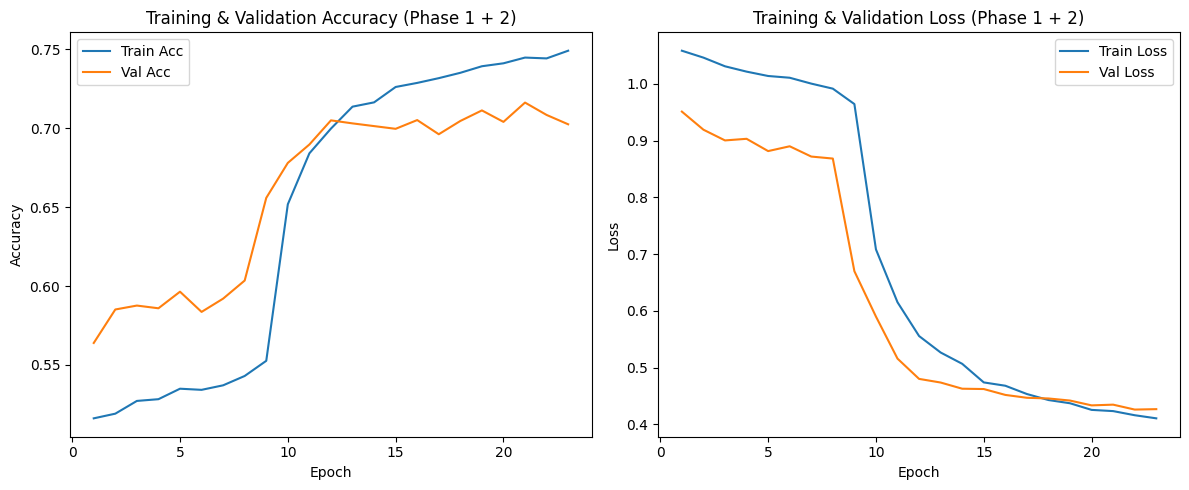


Confusion matrix:
 [[ 315   31   14  796]
 [   4 1282    8   48]
 [   5   15 1317   11]
 [ 429  111   11  831]]
Confusion matrix, without normalization


2025-11-22 14:54:59.457339: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


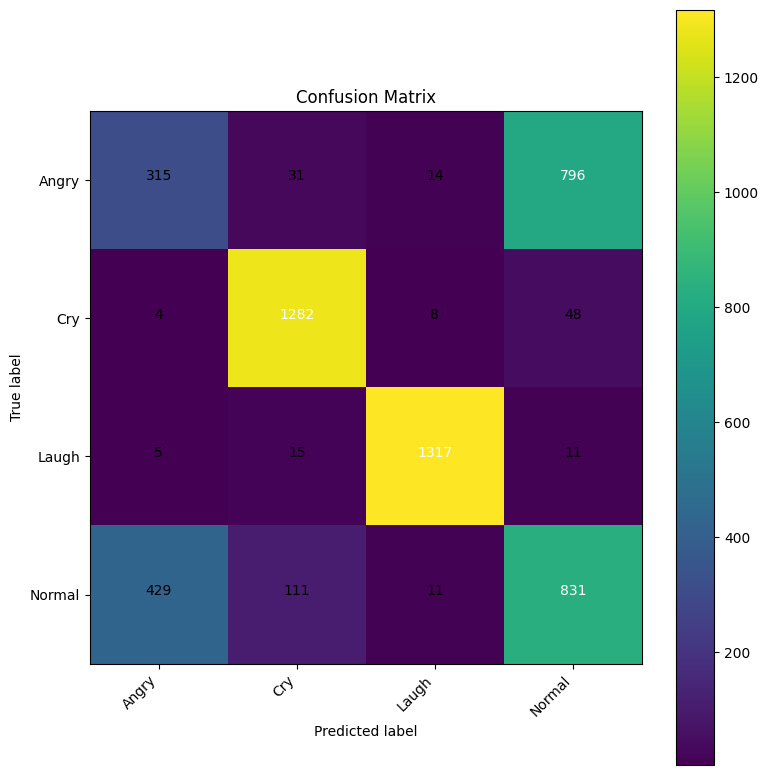

Normalized confusion matrix


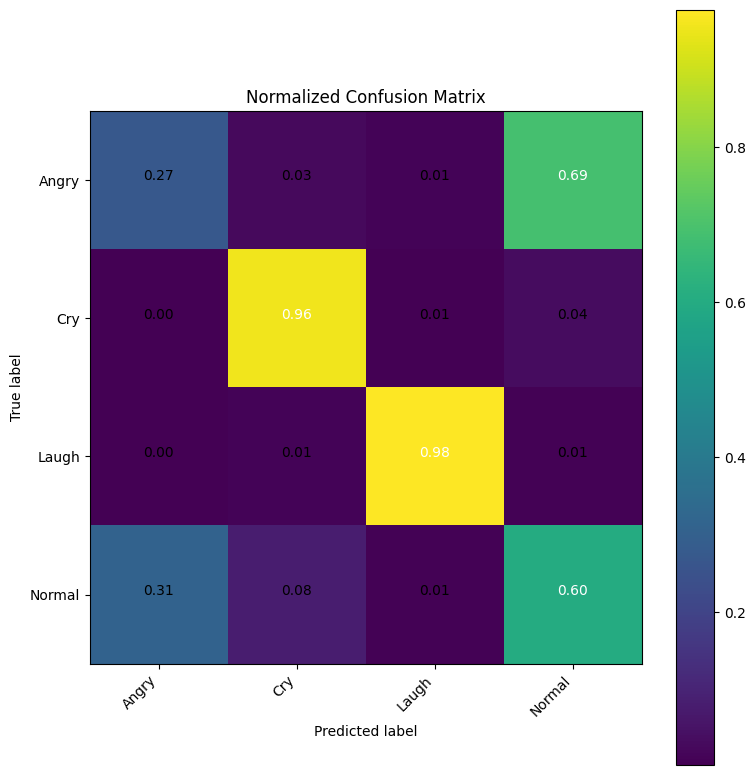


Classification report:

              precision    recall  f1-score   support

       Angry       0.42      0.27      0.33      1156
         Cry       0.89      0.96      0.92      1342
       Laugh       0.98      0.98      0.98      1348
      Normal       0.49      0.60      0.54      1382

    accuracy                           0.72      5228
   macro avg       0.69      0.70      0.69      5228
weighted avg       0.70      0.72      0.70      5228



In [ ]:
# Cell 7: Evaluate model, plot training curves, and show confusion matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# 1) Evaluate on validation set
val_loss, val_acc, val_top3 = model.evaluate(val_ds, verbose=1)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Top-3 Accuracy: {val_top3:.4f}")

# 2) Combine histories from phase 1 and phase 2 for plotting

def concat_histories(h1, h2):
    combined = {}
    for k in h1.history.keys():
        if k in h2.history:
            combined[k] = h1.history[k] + h2.history[k]
        else:
            combined[k] = h1.history[k]
    for k in h2.history.keys():
        if k not in combined:
            combined[k] = [None] * len(h1.history[list(h1.history.keys())[0]]) + h2.history[k]
    return combined

history_all = concat_histories(history_phase1, history_phase2)

# 3) Plot accuracy & loss

epochs_all = range(1, len(history_all["accuracy"]) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_all, history_all["accuracy"], label="Train Acc")
plt.plot(epochs_all, history_all["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy (Phase 1 + 2)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_all, history_all["loss"], label="Train Loss")
plt.plot(epochs_all, history_all["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss (Phase 1 + 2)")
plt.legend()

plt.tight_layout()
plt.show()

# 4) Confusion matrix on validation set

# Get true labels and predictions
y_true = []
y_pred = []

for batch_imgs, batch_labels in val_ds:
    preds = model.predict(batch_imgs, verbose=0)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:\n", cm)

# Pretty plot of confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix"):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(   
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, class_names, normalize=False, title="Confusion Matrix")
plot_confusion_matrix(cm, class_names, normalize=True, title="Normalized Confusion Matrix")

# 5) Classification report
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


In [1]:
import tensorflow as tf
import pathlib
import os

# dataset path
DATA_DIR = "/mnt/d/ai-baby-care/dataset"
data_path = pathlib.Path(DATA_DIR)

IMG_SIZE = (256, 256)
BATCH_SIZE = 16
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(128).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

print("Classes:", class_names)


2025-11-23 05:18:41.510643: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 26143 files belonging to 4 classes.
Using 20915 files for training.


I0000 00:00:1763875141.591456     802 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 26143 files belonging to 4 classes.
Using 5228 files for validation.
Classes: ['Angry', 'Cry', 'Laugh', 'Normal']


In [2]:
from tensorflow import keras

model = keras.models.load_model("checkpoints/best_model_finetuned.keras")
print("Loaded fine-tuned model successfully!")
model.summary()

Loaded fine-tuned model successfully!


Model: "EfficientNetB3_emotion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 256, 256,  │          0 │ input_image[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati

 Total params: 28,724,249 (109.57 MB)

 Trainable params: 8,769,522 (33.45 MB)

 Non-trainable params: 2,415,681 (9.22 MB)

 Optimizer params: 17,539,046 (66.91 MB)

In [3]:
# Evaluate again
val_loss, val_acc, val_top3 = model.evaluate(val_ds, verbose=1)
print(val_loss, val_acc, val_top3)

2025-11-23 05:19:42.337308: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


327/327 ━━━━━━━━━━━━━━━━━━━━ 94s 251ms/step - accuracy: 0.7163 - loss: 0.4349 - top3_acc: 0.9962
0.4349437952041626 0.716335117816925 0.9961744546890259


In [4]:
# Cell: Compute class weights to boost hard classes (like Angry & Normal)

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Collect all labels from the training dataset
all_labels = []
for _, labels in train_ds.unbatch():
    all_labels.append(labels.numpy())

all_labels = np.array(all_labels)

classes = np.unique(all_labels)
print("Classes present in train_ds:", classes)

class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=all_labels
)

class_weights = {int(c): float(w) for c, w in zip(classes, class_weights_arr)}
print("Computed class weights:", class_weights)


2025-11-23 05:24:52.874367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 43 of 128
2025-11-23 05:25:02.875530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 82 of 128
2025-11-23 05:25:18.074753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


Classes present in train_ds: [0 1 2 3]
Computed class weights: {0: 1.1305405405405407, 1: 0.9357104509663565, 2: 0.9468942412169504, 3: 1.009411196911197}


2025-11-23 05:30:04.563847: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# Cell: Short fine-tuning with class weights to improve Angry + Normal performance

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import os

save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

cw_model_path = os.path.join(save_dir, "best_model_finetuned_cw.keras")

callbacks_cw = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=cw_model_path,
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),
]

# Very small LR because we are fine-tuning a model that is already trained
LR = 1e-5
model.compile(
    optimizer=Adam(LR),
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3_acc"),
    ],
)

EPOCHS_CW = 6  # short, safe fine-tuning round

history_cw = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_CW,
    callbacks=callbacks_cw,
    class_weight=class_weights,
    verbose=1
)

print("\n\nSaved best class-weight fine-tuned model at:", cw_model_path)


Epoch 1/6


E0000 00:00:1763876068.097185     802 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/EfficientNetB3_emotion_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-11-23 05:34:40.462290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 76 of 128
2025-11-23 05:34:46.821632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7480 - loss: 0.4374 - top3_acc: 0.9984
Epoch 1: val_accuracy improved from None to 0.70314, saving model to checkpoints/best_model_finetuned_cw.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 380s 258ms/step - accuracy: 0.7485 - loss: 0.4278 - top3_acc: 0.9988 - val_accuracy: 0.7031 - val_loss: 0.4193 - val_top3_acc: 0.9973 - learning_rate: 1.0000e-05
Epoch 2/6
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.7459 - loss: 0.4241 - top3_acc: 0.9990
Epoch 2: val_accuracy improved from 0.70314 to 0.70486, saving model to checkpoints/best_model_finetuned_cw.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 325s 247ms/step - accuracy: 0.7502 - loss: 0.4211 - top3_acc: 0.9991 - val_accuracy: 0.7049 - val_loss: 0.4190 - val_top3_acc: 0.9981 - learning_rate: 1.0000e-05
Epoch 3/6
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7529 - loss: 0.4175 - top3_acc: 0.9992
Epoch 3: val_accuracy did not improve from 0.70486
1308/1308 ━━━━━━━━━━━━━━

2025-11-23 05:51:20.873350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 118 of 128
2025-11-23 05:51:21.127817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-11-23 05:51:21.128568: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 12583232 bytes after encountering the first element of size 12583232 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.7506 - loss: 0.4156 - top3_acc: 0.9990
Epoch 4: val_accuracy improved from 0.70486 to 0.70562, saving model to checkpoints/best_model_finetuned_cw.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 349s 259ms/step - accuracy: 0.7539 - loss: 0.4127 - top3_acc: 0.9990 - val_accuracy: 0.7056 - val_loss: 0.4167 - val_top3_acc: 0.9987 - learning_rate: 1.0000e-05
Epoch 5/6


2025-11-23 05:57:09.912771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 79 of 128
2025-11-23 05:57:15.497328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.7516 - loss: 0.4135 - top3_acc: 0.9993
Epoch 5: val_accuracy improved from 0.70562 to 0.70601, saving model to checkpoints/best_model_finetuned_cw.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 356s 260ms/step - accuracy: 0.7552 - loss: 0.4103 - top3_acc: 0.9994 - val_accuracy: 0.7060 - val_loss: 0.4163 - val_top3_acc: 0.9979 - learning_rate: 1.0000e-05
Epoch 6/6


2025-11-23 06:03:06.084412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 76 of 128
2025-11-23 06:03:12.505810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.7568 - loss: 0.4100 - top3_acc: 0.9990
Epoch 6: val_accuracy did not improve from 0.70601
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 360s 262ms/step - accuracy: 0.7571 - loss: 0.4059 - top3_acc: 0.9993 - val_accuracy: 0.7058 - val_loss: 0.4172 - val_top3_acc: 0.9981 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 5.


Saved best class-weight fine-tuned model at: checkpoints/best_model_finetuned_cw.keras


In [6]:
model = keras.models.load_model(cw_model_path)
model.evaluate(val_ds)

327/327 ━━━━━━━━━━━━━━━━━━━━ 45s 119ms/step - accuracy: 0.7060 - loss: 0.4163 - top3_acc: 0.9979


[0.41625723242759705, 0.7060061097145081, 0.9978959560394287]

2025-11-23 06:18:32.937217: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Confusion matrix (raw):
 [[ 812   11    8  325]
 [   5 1276    8   53]
 [   9    8 1325    6]
 [1001   96    7  278]]

Confusion matrix, without normalization:


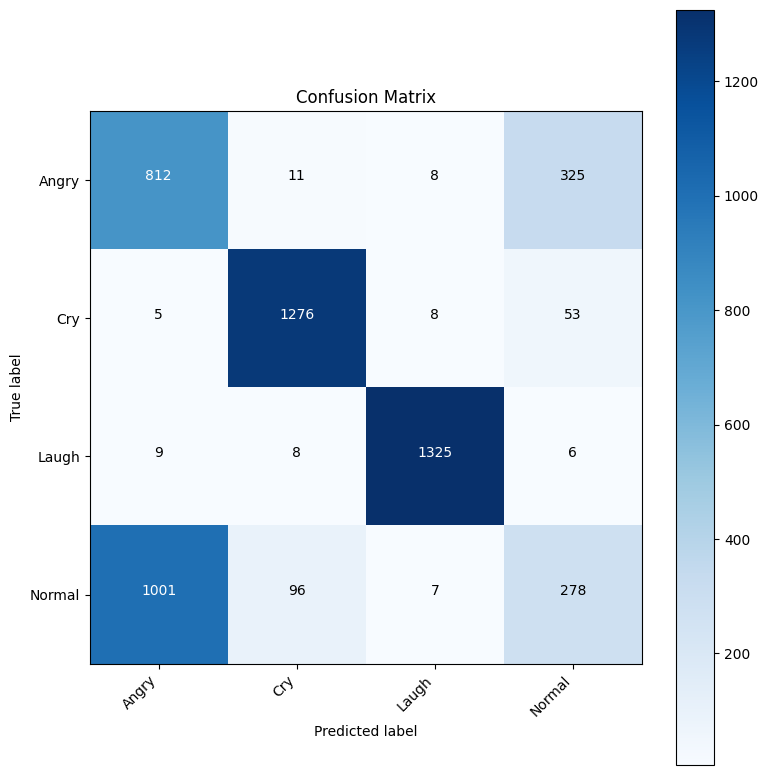


Normalized confusion matrix:


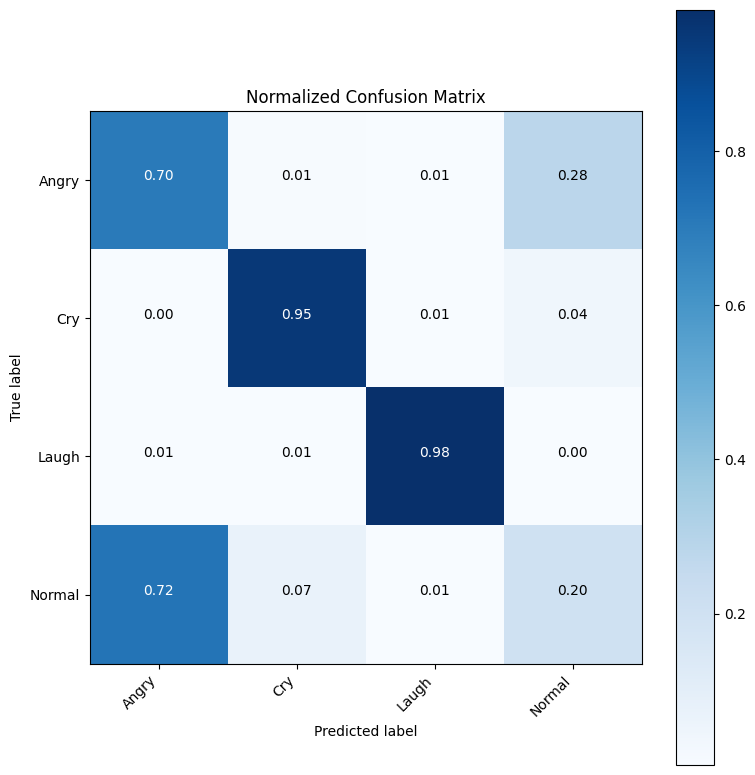


Classification Report:

              precision    recall  f1-score   support

       Angry       0.44      0.70      0.54      1156
         Cry       0.92      0.95      0.93      1342
       Laugh       0.98      0.98      0.98      1348
      Normal       0.42      0.20      0.27      1382

    accuracy                           0.71      5228
   macro avg       0.69      0.71      0.68      5228
weighted avg       0.70      0.71      0.69      5228



In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# 1) Collect predictions and true labels
y_true = []
y_pred = []

for batch_imgs, batch_labels in val_ds:
    preds = model.predict(batch_imgs, verbose=0)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2) Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (raw):\n", cm)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix"):
    if normalize:
        cm_plot = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        title = "Normalized Confusion Matrix"
        print("\nNormalized confusion matrix:")
    else:
        cm_plot = cm
        print("\nConfusion matrix, without normalization:")

    plt.figure(figsize=(8,8))
    plt.imshow(cm_plot, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm_plot.max() / 2.

    for i, j in itertools.product(range(cm_plot.shape[0]), range(cm_plot.shape[1])):
        plt.text(j, i, format(cm_plot[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_plot[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# 3) Plot raw + normalized confusion matrices
plot_confusion_matrix(cm, class_names, normalize=False)
plot_confusion_matrix(cm, class_names, normalize=True)

# 4) Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


In [8]:
from tensorflow import keras
import os

save_dir = "checkpoints"
base_finetuned_path = os.path.join(save_dir, "best_model_finetuned.keras")

model = keras.models.load_model(base_finetuned_path)
print("Loaded base fine-tuned model from:", base_finetuned_path)
model.summary()


Loaded base fine-tuned model from: checkpoints/best_model_finetuned.keras


Model: "EfficientNetB3_emotion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 256, 256,  │          0 │ input_image[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati

 Total params: 28,724,249 (109.57 MB)

 Trainable params: 8,769,522 (33.45 MB)

 Non-trainable params: 2,415,681 (9.22 MB)

 Optimizer params: 17,539,046 (66.91 MB)

In [9]:
# Manual class weights to slightly prefer Angry and strongly prefer Normal

# Assuming class_names order is: ['Angry', 'Cry', 'Laugh', 'Normal']
print("Class names:", class_names)

class_weights = {
    0: 1.2,  # Angry
    1: 0.9,  # Cry
    2: 0.9,  # Laugh
    3: 1.6,  # Normal
}

print("Using manual class weights:", class_weights)


Class names: ['Angry', 'Cry', 'Laugh', 'Normal']
Using manual class weights: {0: 1.2, 1: 0.9, 2: 0.9, 3: 1.6}


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

balanced_cw_path = os.path.join(save_dir, "best_model_finetuned_balanced_cw.keras")

callbacks_balanced = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=balanced_cw_path,
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),
]

# Very small LR to avoid wrecking good weights
LR = 1e-5
model.compile(
    optimizer=Adam(LR),
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3_acc"),
    ],
)

EPOCHS_BALANCED = 6

history_balanced = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_BALANCED,
    callbacks=callbacks_balanced,
    class_weight=class_weights,
    verbose=1
)

print("\nBest balanced CW model saved at:", balanced_cw_path)


Epoch 1/6


E0000 00:00:1763879064.923219     802 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/EfficientNetB3_emotion_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-11-23 06:24:38.342632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 74 of 128
2025-11-23 06:24:45.085900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-11-23 06:24:45.086210: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 12583168 bytes after encountering the first element of size 12583168 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-11-23 06:24:45.092447: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Pre

1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.7421 - loss: 0.5572 - top3_acc: 0.9986
Epoch 1: val_accuracy improved from None to 0.73795, saving model to checkpoints/best_model_finetuned_balanced_cw.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 422s 289ms/step - accuracy: 0.7455 - loss: 0.5406 - top3_acc: 0.9990 - val_accuracy: 0.7379 - val_loss: 0.4179 - val_top3_acc: 0.9979 - learning_rate: 1.0000e-05
Epoch 2/6


2025-11-23 06:31:13.263427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 78 of 128


   1/1308 ━━━━━━━━━━━━━━━━━━━━ 5:57:38 16s/step - accuracy: 0.8750 - loss: 0.4946 - top3_acc: 1.0000

2025-11-23 06:31:19.382493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-11-23 06:31:19.387732: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 12583232 bytes after encountering the first element of size 12583232 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7508 - loss: 0.5277 - top3_acc: 0.9989
Epoch 2: val_accuracy improved from 0.73795 to 0.74139, saving model to checkpoints/best_model_finetuned_balanced_cw.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 357s 261ms/step - accuracy: 0.7476 - loss: 0.5264 - top3_acc: 0.9988 - val_accuracy: 0.7414 - val_loss: 0.4154 - val_top3_acc: 0.9981 - learning_rate: 1.0000e-05
Epoch 3/6


2025-11-23 06:37:10.309851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 82 of 128
2025-11-23 06:37:15.766133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-11-23 06:37:15.771877: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 12583232 bytes after encountering the first element of size 12583232 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7473 - loss: 0.5229 - top3_acc: 0.9992
Epoch 3: val_accuracy improved from 0.74139 to 0.74197, saving model to checkpoints/best_model_finetuned_balanced_cw.keras
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 352s 257ms/step - accuracy: 0.7470 - loss: 0.5212 - top3_acc: 0.9994 - val_accuracy: 0.7420 - val_loss: 0.4140 - val_top3_acc: 0.9981 - learning_rate: 1.0000e-05
Epoch 4/6


2025-11-23 06:42:53.920010: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 12583232 bytes after encountering the first element of size 12583232 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7534 - loss: 0.5244 - top3_acc: 0.9995
Epoch 4: val_accuracy did not improve from 0.74197
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 336s 255ms/step - accuracy: 0.7499 - loss: 0.5215 - top3_acc: 0.9993 - val_accuracy: 0.7410 - val_loss: 0.4131 - val_top3_acc: 0.9985 - learning_rate: 1.0000e-05
Epoch 5/6


2025-11-23 06:48:38.211779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 80 of 128
2025-11-23 06:48:44.103399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-11-23 06:48:44.103554: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 16777472 bytes after encountering the first element of size 16777472 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-11-23 06:48:44.106120: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 16777536 bytes after encountering the first element of size 16777536 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7493 - loss: 0.5292 - top3_acc: 0.9991
Epoch 5: val_accuracy did not improve from 0.74197
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 422s 310ms/step - accuracy: 0.7512 - loss: 0.5190 - top3_acc: 0.9993 - val_accuracy: 0.7397 - val_loss: 0.4149 - val_top3_acc: 0.9985 - learning_rate: 1.0000e-05
Epoch 6/6
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7531 - loss: 0.5205 - top3_acc: 0.9991
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.

Epoch 6: val_accuracy did not improve from 0.74197
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 325s 246ms/step - accuracy: 0.7522 - loss: 0.5140 - top3_acc: 0.9994 - val_accuracy: 0.7389 - val_loss: 0.4131 - val_top3_acc: 0.9985 - learning_rate: 1.0000e-05
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.

Best balanced CW model saved at: checkpoints/best_model_finetuned_balanced_cw.keras


In [11]:
# Load best from this run
from tensorflow import keras

model = keras.models.load_model(balanced_cw_path)
val_loss, val_acc, val_top3 = model.evaluate(val_ds, verbose=1)
print("\nBalanced CW -> val_loss, val_acc, val_top3:", val_loss, val_acc, val_top3)

327/327 ━━━━━━━━━━━━━━━━━━━━ 47s 121ms/step - accuracy: 0.7420 - loss: 0.4140 - top3_acc: 0.9981

Balanced CW -> val_loss, val_acc, val_top3: 0.41399329900741577 0.7419663071632385 0.9980872273445129


327/327 ━━━━━━━━━━━━━━━━━━━━ 38s 116ms/step - accuracy: 0.7420 - loss: 0.4140 - top3_acc: 0.9981

Val Loss: 0.41399332880973816
Val Accuracy: 0.7419663071632385
Val Top-3 Accuracy: 0.9980872273445129

Confusion Matrix:
 [[  28    8    7 1113]
 [   1 1233    5  103]
 [   1    7 1326   14]
 [  61   25    4 1292]]


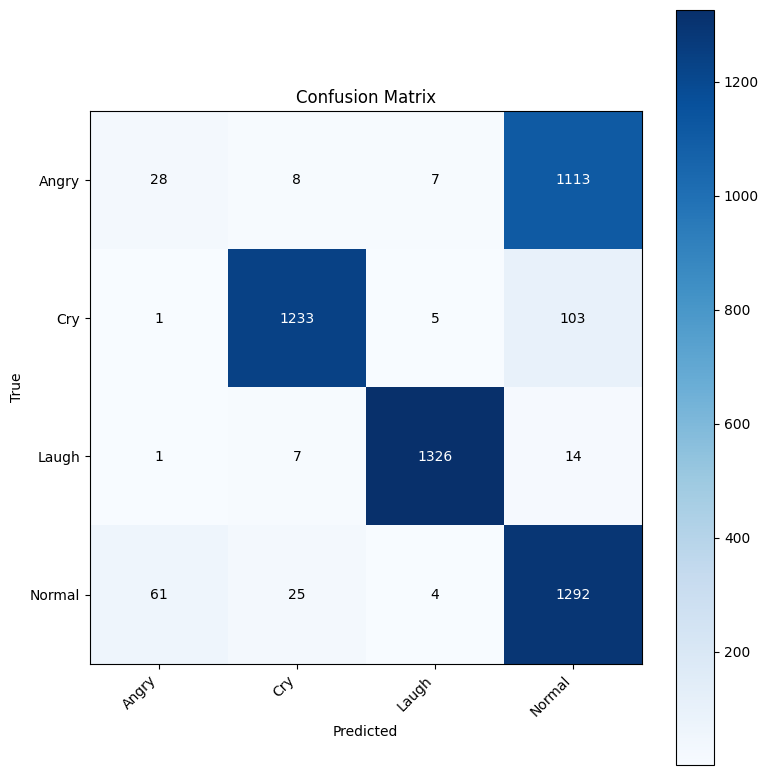

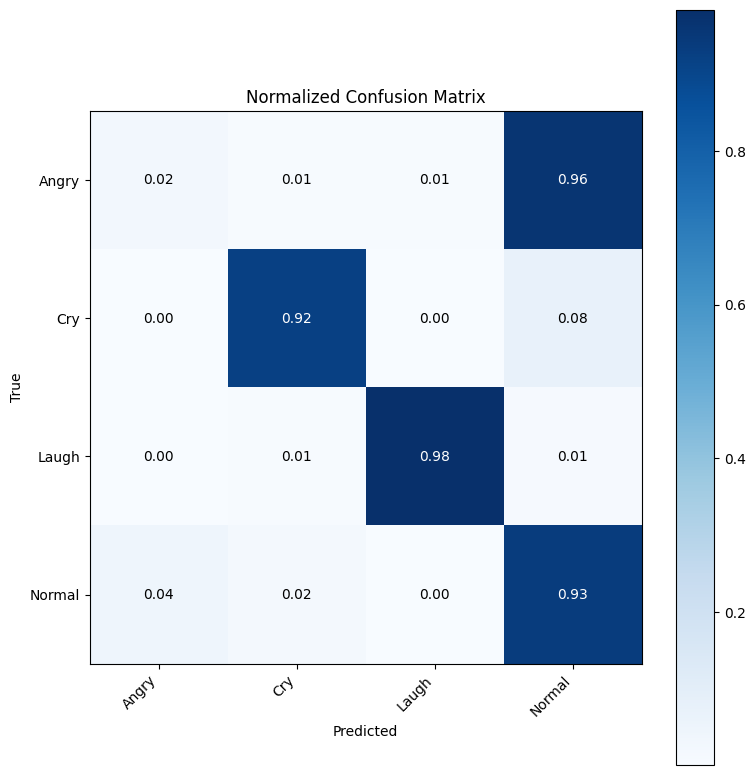


Classification Report:

              precision    recall  f1-score   support

       Angry       0.31      0.02      0.04      1156
         Cry       0.97      0.92      0.94      1342
       Laugh       0.99      0.98      0.99      1348
      Normal       0.51      0.93      0.66      1382

    accuracy                           0.74      5228
   macro avg       0.69      0.72      0.66      5228
weighted avg       0.71      0.74      0.68      5228



In [13]:
# Cell B: Confusion matrix + classification report ONLY (NO history needed)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Evaluate
val_loss, val_acc, val_top3 = model.evaluate(val_ds, verbose=1)
print("\nVal Loss:", val_loss)
print("Val Accuracy:", val_acc)
print("Val Top-3 Accuracy:", val_top3)

# Collect predictions
y_true = []
y_pred = []

for batch_imgs, batch_labels in val_ds:
    preds = model.predict(batch_imgs, verbose=0)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

def plot_cm(cm, classes, normalize=False, title="Confusion Matrix"):
    if normalize:
        cm2 = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        title = "Normalized Confusion Matrix"
    else:
        cm2 = cm

    plt.figure(figsize=(8,8))
    plt.imshow(cm2, cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
    plt.yticks(range(len(classes)), classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm2.max() / 2.

    for i in range(cm2.shape[0]):
        for j in range(cm2.shape[1]):
            plt.text(j, i, format(cm2[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm2[i, j] > thresh else "black")

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

plot_cm(cm, class_names, normalize=False)
plot_cm(cm, class_names, normalize=True)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

In [5]:
import tensorflow as tf
import pathlib

DATA_DIR = "/mnt/d/ai-baby-care/dataset"
data_path = pathlib.Path(DATA_DIR)

IMG_SIZE = (256, 256)
BATCH_SIZE = 16
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(128).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

Found 26143 files belonging to 4 classes.
Using 20915 files for training.


I0000 00:00:1763883414.450537   50253 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 26143 files belonging to 4 classes.
Using 5228 files for validation.
Classes: ['Angry', 'Cry', 'Laugh', 'Normal']


In [6]:
print("Class names:", class_names)
# Adjust these if your order is different
angry_index = class_names.index("Angry")
normal_index = class_names.index("Normal")
print("Angry index:", angry_index, "Normal index:", normal_index)

def to_binary_labels(images, labels):
    bin_labels = tf.cast(tf.equal(labels, angry_index), tf.int32)
    return images, bin_labels

bin_train_ds = train_ds.map(to_binary_labels)
bin_val_ds = val_ds.map(to_binary_labels)

AUTOTUNE = tf.data.AUTOTUNE
bin_train_ds = bin_train_ds.prefetch(AUTOTUNE)
bin_val_ds = bin_val_ds.prefetch(AUTOTUNE)

# Distribution check
pos = neg = 0
for _, lbl in bin_train_ds.unbatch():
    if int(lbl) == 1:
        pos += 1
    else:
        neg += 1

print(f"Binary train distribution -> Angry(1): {pos}, NotAngry(0): {neg}")

Class names: ['Angry', 'Cry', 'Laugh', 'Normal']
Angry index: 0 Normal index: 3
Binary train distribution -> Angry(1): 4625, NotAngry(0): 16290


2025-11-23 07:40:09.348972: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
# Cell 2: Define a small CNN for Angry vs Not-Angry

from tensorflow import keras
from tensorflow.keras import layers, Model

print("Using IMG_SIZE:", IMG_SIZE)

inputs_bin = layers.Input(shape=IMG_SIZE + (3,), name="input_image_bin")

# Light augmentation
x = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.05, 0.05),
    ],
    name="data_aug_bin",
)(inputs_bin)

x = layers.Rescaling(1.0 / 255)(x)

# Simple CNN backbone
x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

# Binary output: 1 = Angry, 0 = Not-Angry
outputs_bin = layers.Dense(1, activation="sigmoid", name="angry_prob")(x)

angry_model = Model(inputs_bin, outputs_bin, name="AngryVsNotAngry_CNN")

angry_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

angry_model.summary()

Using IMG_SIZE: (256, 256)


Model: "AngryVsNotAngry_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image_bin (InputLayer)    │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_aug_bin (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ angry_prob (Dense)              │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,977 (1.61 MB)

 Trainable params: 422,209 (1.61 MB)

 Non-trainable params: 768 (3.00 KB)

In [8]:
# Cell 3: Compute binary class weights (0 = Not-Angry, 1 = Angry)

from sklearn.utils.class_weight import compute_class_weight

all_bin_labels = []
for _, lbl in bin_train_ds.unbatch():
    all_bin_labels.append(int(lbl.numpy()))

all_bin_labels = np.array(all_bin_labels)
bin_classes = np.unique(all_bin_labels)

bin_class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=bin_classes,
    y=all_bin_labels,
)

bin_class_weights = {
    int(c): float(w) for c, w in zip(bin_classes, bin_class_weights_arr)
}
print("Binary class weights:", bin_class_weights)

Binary class weights: {0: 0.6419582565991406, 1: 2.2610810810810813}


2025-11-23 07:45:47.827828: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# Cell 4: OOM-safe training for Angry vs Not-Angry classifier

import os, gc, tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Clear any old graphs from memory
tf.keras.backend.clear_session()
gc.collect()
print("Cleared TF session and ran GC.")

# Re-batch to smaller batch size to reduce VRAM
BIN_BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

bin_train_small = bin_train_ds.unbatch().batch(BIN_BATCH_SIZE).prefetch(AUTOTUNE)
bin_val_small   = bin_val_ds.unbatch().batch(BIN_BATCH_SIZE).prefetch(AUTOTUNE)

print("Re-batched binary datasets to batch size:", BIN_BATCH_SIZE)

# Re-compile angry_model (after clear_session, if needed, re-run Cell 2 before this)
angry_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Checkpoints
bin_save_dir = "checkpoints"
os.makedirs(bin_save_dir, exist_ok=True)
angry_best_path = os.path.join(bin_save_dir, "angry_vs_notangry_best.keras")

callbacks_bin = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=4,
        restore_best_weights=True,
        verbose=1,
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=2,
        min_lr=1e-6,
        verbose=1,
    ),
    ModelCheckpoint(
        filepath=angry_best_path,
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1,
    ),
]

EPOCHS_BIN = 12

history_angry = angry_model.fit(
    bin_train_small,
    validation_data=bin_val_small,
    epochs=EPOCHS_BIN,
    callbacks=callbacks_bin,
    class_weight=bin_class_weights,  # if you want no weights, remove this arg
    verbose=1,
)

print("\nBest Angry vs Not-Angry model saved at:", angry_best_path)

Cleared TF session and ran GC.
Re-batched binary datasets to batch size: 8
Epoch 1/12


2025-11-23 07:46:50.611825: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


   2615/Unknown 113s 40ms/step - accuracy: 0.4957 - loss: 0.8037

2025-11-23 07:48:37.899223: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/binary_crossentropy/mul/Shape_1/_84]]
2025-11-23 07:48:37.899317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13696021828298143689
2025-11-23 07:48:37.899325: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6751427036560692026
2025-11-23 07:48:37.899328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6308860101176239300
/home/shrey/tf_gpu/venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to u


Epoch 1: val_accuracy improved from None to 0.72475, saving model to checkpoints/angry_vs_notangry_best.keras
2615/2615 ━━━━━━━━━━━━━━━━━━━━ 198s 72ms/step - accuracy: 0.4995 - loss: 0.7557 - val_accuracy: 0.7248 - val_loss: 0.5869 - learning_rate: 0.0010
Epoch 2/12


2025-11-23 07:50:02.350502: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2393924871465196951
2025-11-23 07:50:02.350590: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10990166001677432143
2025-11-23 07:50:02.350598: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11449271368738425036
2025-11-23 07:50:12.688032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 46 of 128
2025-11-23 07:50:23.546558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2615/2615 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4888 - loss: 0.7044

2025-11-23 07:53:14.064507: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/binary_crossentropy/mul/Shape_1/_84]]
2025-11-23 07:53:14.064601: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13696021828298143689
2025-11-23 07:53:14.064613: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6751427036560692026
2025-11-23 07:53:14.064617: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6308860101176239300



Epoch 2: val_accuracy did not improve from 0.72475
2615/2615 ━━━━━━━━━━━━━━━━━━━━ 232s 81ms/step - accuracy: 0.4972 - loss: 0.7026 - val_accuracy: 0.3168 - val_loss: 0.7297 - learning_rate: 0.0010
Epoch 3/12


2025-11-23 07:53:54.365309: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2154793157308674293
2025-11-23 07:53:54.365375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2393924871465196951
2025-11-23 07:53:54.365381: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10990166001677432143
2025-11-23 07:53:54.365388: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11449271368738425036
2025-11-23 07:54:04.413888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 79 of 128
2025-11-23 07:54:10.075425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


2614/2615 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4883 - loss: 0.6981

2025-11-23 07:56:44.285389: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6645108523820456161
2025-11-23 07:56:44.285909: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 15922627038101710813
2025-11-23 07:56:44.285917: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 16159375200762034911
2025-11-23 07:56:44.285919: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 4154089078909798444
2025-11-23 07:56:44.285933: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3010872590962900169
2025-11-23 07:56:44.285936: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 8384027044588188823
2025-11-23 07:56:44.285938: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 3: val_accuracy did not improve from 0.72475
2615/2615 ━━━━━━━━━━━━━━━━━━━━ 210s 74ms/step - accuracy: 0.4857 - loss: 0.7008 - val_accuracy: 0.5954 - val_loss: 0.6619 - learning_rate: 0.0010
Epoch 4/12


2025-11-23 07:57:24.219267: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2154793157308674293
2025-11-23 07:57:24.219332: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2393924871465196951
2025-11-23 07:57:24.219340: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10990166001677432143
2025-11-23 07:57:24.219345: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11449271368738425036
2025-11-23 07:57:34.548637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 80 of 128
2025-11-23 07:57:40.196141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-11-23 07:57:40.197590: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 125

2615/2615 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4866 - loss: 0.6961

2025-11-23 08:00:13.106308: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/binary_crossentropy/mul/Shape_1/_84]]
2025-11-23 08:00:13.106379: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13696021828298143689
2025-11-23 08:00:13.106408: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6751427036560692026
2025-11-23 08:00:13.106415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6308860101176239300
2025-11-23 08:00:13.867828: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 16772928 bytes after encountering the first element of size 16772928 bytes.This already causes the autotune ram budget to be exceeded. To stay within the


Epoch 4: val_accuracy did not improve from 0.72475
2615/2615 ━━━━━━━━━━━━━━━━━━━━ 209s 74ms/step - accuracy: 0.4956 - loss: 0.6946 - val_accuracy: 0.2276 - val_loss: 0.8144 - learning_rate: 3.0000e-04
Epoch 5/12


2025-11-23 08:00:52.997071: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2393924871465196951
2025-11-23 08:00:52.997116: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10990166001677432143
2025-11-23 08:00:52.997126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11449271368738425036
2025-11-23 08:01:03.065747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 85 of 128
2025-11-23 08:01:08.544577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-11-23 08:01:08.548991: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 12582976 bytes after encountering the first element of size 12582976 bytes.This already causes the autotune ram budget to be exceeded. To stay within th

2614/2615 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4990 - loss: 0.6904

2025-11-23 08:03:41.728534: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13696021828298143689
2025-11-23 08:03:41.728582: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6751427036560692026
2025-11-23 08:03:41.728589: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6308860101176239300
2025-11-23 08:03:42.366913: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 16772928 bytes after encountering the first element of size 16772928 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 5: val_accuracy did not improve from 0.72475
2615/2615 ━━━━━━━━━━━━━━━━━━━━ 208s 74ms/step - accuracy: 0.5005 - loss: 0.6923 - val_accuracy: 0.7179 - val_loss: 0.6403 - learning_rate: 3.0000e-04
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.

Best Angry vs Not-Angry model saved at: checkpoints/angry_vs_notangry_best.keras


2025-11-23 08:04:21.340424: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2393924871465196951
2025-11-23 08:04:21.340464: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10990166001677432143
2025-11-23 08:04:21.340471: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11449271368738425036


In [10]:
bin_val_loss, bin_val_acc = angry_model.evaluate(bin_val_small, verbose=1)
print("Binary Angry vs Not-Angry -> val_loss, val_acc:", bin_val_loss, bin_val_acc)

654/654 ━━━━━━━━━━━━━━━━━━━━ 75s 108ms/step - accuracy: 0.7248 - loss: 0.5869
Binary Angry vs Not-Angry -> val_loss, val_acc: 0.5869222283363342 0.724751353263855


2025-11-23 14:22:58.441689: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2154793157308674293
2025-11-23 14:22:58.443027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2393924871465196951
2025-11-23 14:22:58.443040: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10990166001677432143
2025-11-23 14:22:58.443354: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11449271368738425036


Loaded 4-class model from: checkpoints/best_model_finetuned_balanced_cw.keras
Loaded Angry binary model from: checkpoints/angry_vs_notangry_best.keras
Class names: ['Angry', 'Cry', 'Laugh', 'Normal']
Angry index: 0 Normal index: 3

Stage 1 only accuracy: 0.7419663351185922
Pipeline (Stage1 + Stage2) accuracy: 0.7425401683244071

Pipeline Confusion Matrix:
 [[  76    8    7 1065]
 [  11 1233    5   93]
 [   1    7 1326   14]
 [ 106   25    4 1247]]


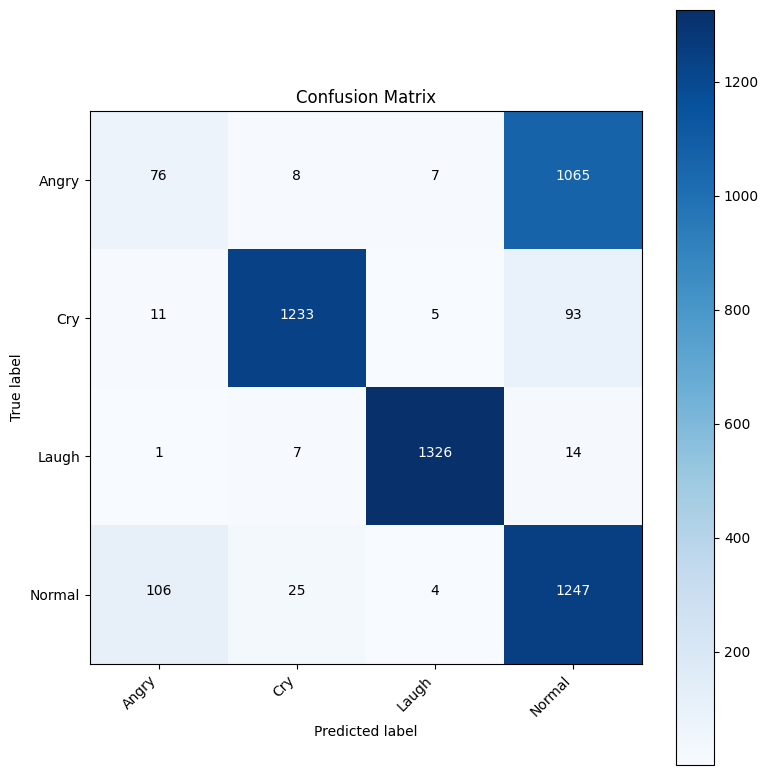

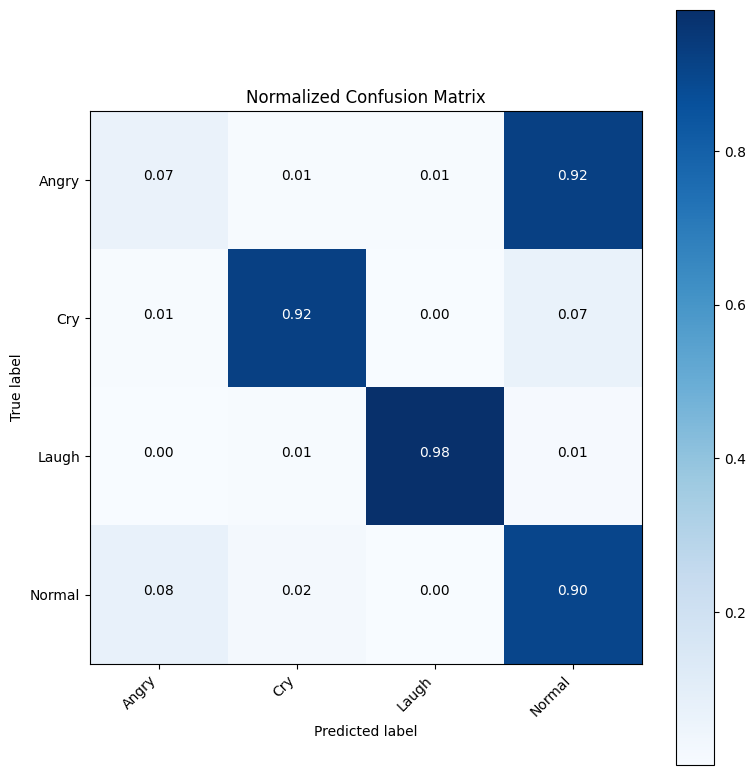


Pipeline Classification Report:

              precision    recall  f1-score   support

       Angry       0.39      0.07      0.11      1156
         Cry       0.97      0.92      0.94      1342
       Laugh       0.99      0.98      0.99      1348
      Normal       0.52      0.90      0.66      1382

    accuracy                           0.74      5228
   macro avg       0.72      0.72      0.67      5228
weighted avg       0.73      0.74      0.69      5228



In [11]:
# Cell: Two-stage pipeline evaluation (4-class model + Angry specialist)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from tensorflow import keras

# 1) Load models (adjust paths if needed)
four_class_path = "checkpoints/best_model_finetuned_balanced_cw.keras"          # 4-class EfficientNet model
angry_best_path = "checkpoints/angry_vs_notangry_best.keras"        # binary Angry vs Not-Angry model

model = keras.models.load_model(four_class_path)
angry_model = keras.models.load_model(angry_best_path)

print("Loaded 4-class model from:", four_class_path)
print("Loaded Angry binary model from:", angry_best_path)
print("Class names:", class_names)

# Ensure indices
angry_index = class_names.index("Angry")
normal_index = class_names.index("Normal")
print("Angry index:", angry_index, "Normal index:", normal_index)

# 2) Two-stage inference: Stage1 (4-class) + Stage2 (Angry vs NotAngry)
ANGRY_THRESHOLD = 0.5   # you can tweak this: 0.4 for more Angry recall, 0.6 for less false Angry

y_true_all = []
y_pred_stage1 = []
y_pred_pipeline = []

for batch_imgs, batch_labels in val_ds:
    batch_np = batch_imgs.numpy()
    batch_labels_np = batch_labels.numpy()

    # Stage 1: 4-class probabilities
    probs_stage1 = model.predict(batch_np, verbose=0)
    preds_stage1 = np.argmax(probs_stage1, axis=1)

    # Stage 2: Angry vs Not-Angry probabilities for same images
    probs_angry = angry_model.predict(batch_np, verbose=0).reshape(-1)  # sigmoid output

    final_preds = preds_stage1.copy()

    for i in range(len(batch_np)):
        top_class = preds_stage1[i]
        top_name = class_names[top_class]

        if top_name in ["Cry", "Laugh"]:
            # Trust Stage 1 directly for these (already very strong)
            final_preds[i] = top_class
        else:
            # Candidate: Angry or Normal -> ask binary expert
            angry_prob = probs_angry[i]
            if angry_prob >= ANGRY_THRESHOLD:
                final_preds[i] = angry_index
            else:
                final_preds[i] = normal_index

    y_true_all.extend(batch_labels_np)
    y_pred_stage1.extend(preds_stage1)
    y_pred_pipeline.extend(final_preds)

y_true_all = np.array(y_true_all)
y_pred_stage1 = np.array(y_pred_stage1)
y_pred_pipeline = np.array(y_pred_pipeline)

# 3) Compare accuracies
acc_stage1 = np.mean(y_pred_stage1 == y_true_all)
acc_pipeline = np.mean(y_pred_pipeline == y_true_all)

print("\nStage 1 only accuracy:", acc_stage1)
print("Pipeline (Stage1 + Stage2) accuracy:", acc_pipeline)

# 4) Confusion matrix for pipeline
cm_pipe = confusion_matrix(y_true_all, y_pred_pipeline)
print("\nPipeline Confusion Matrix:\n", cm_pipe)

def plot_cm(cm, classes, normalize=False, title="Confusion Matrix"):
    if normalize:
        cm2 = cm.astype("float") / cm.sum(axis=1, keepdims=True)
        title = "Normalized Confusion Matrix"
    else:
        cm2 = cm

    plt.figure(figsize=(8,8))
    plt.imshow(cm2, cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm2.max() / 2.
    for i, j in itertools.product(range(cm2.shape[0]), range(cm2.shape[1])):
        plt.text(
            j,
            i,
            format(cm2[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm2[i, j] > thresh else "black",
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

plot_cm(cm_pipe, class_names, normalize=False)
plot_cm(cm_pipe, class_names, normalize=True)

print("\nPipeline Classification Report:\n")
print(classification_report(y_true_all, y_pred_pipeline, target_names=class_names))

In [12]:
from pathlib import Path

DATA_DIR = Path("/mnt/d/ai-baby-care/dataset")

class_counts = {}
for class_dir in DATA_DIR.iterdir():
    if class_dir.is_dir():
        n_images = len(list(class_dir.glob("*.jpg"))) + len(list(class_dir.glob("*.png"))) + len(list(class_dir.glob("*.jpeg")))
        class_counts[class_dir.name] = n_images

print("Class image counts:")
for cls, n in class_counts.items():
    print(f"{cls}: {n}")

# Choose target count = max of all classes
target_count = max(class_counts.values())
print("\nTarget count per class (for balancing):", target_count)

Class image counts:
Angry: 5781
Cry: 6930
Laugh: 6870
Normal: 400

Target count per class (for balancing): 6930


In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import numpy as np

DATA_DIR = Path("/mnt/d/ai-baby-care/dataset")
normal_dir = DATA_DIR / "Normal"

# Reuse same IMG_SIZE as training
IMG_SIZE = (256, 256)   # or (300, 300) if you decide to go bigger later

# Augmentation pipeline for offline normal images
offline_aug = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.15),
        layers.RandomTranslation(0.1, 0.1),
    ]
)

# List original Normal images
normal_images = list(normal_dir.glob("*.jpg")) + list(normal_dir.glob("*.png")) + list(normal_dir.glob("*.jpeg"))
print("Original Normal images:", len(normal_images))

current_count = len(normal_images)

print("Current Normal count:", current_count)
print("Target count:", target_count)

if current_count >= target_count:
    print("Normal already has >= target_count images, no offline augmentation needed.")
else:
    # Helper to load an image as tensor
    def load_image(path):
        img = tf.keras.utils.load_img(path, target_size=IMG_SIZE)
        arr = tf.keras.utils.img_to_array(img)
        arr = tf.expand_dims(arr, 0)  # add batch axis
        return arr

    aug_idx = 0
    img_idx = 0
    normal_images_cycle = normal_images.copy()

    while current_count < target_count:
        if img_idx >= len(normal_images_cycle):
            img_idx = 0  # loop over images

        img_path = normal_images_cycle[img_idx]
        img_idx += 1

        # Load + augment
        img_tensor = load_image(img_path)              # shape (1, H, W, 3)
        aug_tensor = offline_aug(img_tensor, training=True)  # apply random transforms
        aug_img = tf.keras.utils.array_to_img(aug_tensor[0])

        # Save augmented image
        save_name = f"aug_normal_{aug_idx:06d}.jpg"
        save_path = normal_dir / save_name
        aug_img.save(save_path)

        aug_idx += 1
        current_count += 1

        if aug_idx % 100 == 0:
            print(f"Generated {aug_idx} augmented Normal images, total Normal now {current_count}")

    print(f"Done! Final Normal count should be ≈ {current_count}")


Original Normal images: 400
Current Normal count: 400
Target count: 6930
Generated 100 augmented Normal images, total Normal now 500
Generated 200 augmented Normal images, total Normal now 600
Generated 300 augmented Normal images, total Normal now 700
Generated 400 augmented Normal images, total Normal now 800
Generated 500 augmented Normal images, total Normal now 900
Generated 600 augmented Normal images, total Normal now 1000
Generated 700 augmented Normal images, total Normal now 1100
Generated 800 augmented Normal images, total Normal now 1200
Generated 900 augmented Normal images, total Normal now 1300
Generated 1000 augmented Normal images, total Normal now 1400
Generated 1100 augmented Normal images, total Normal now 1500
Generated 1200 augmented Normal images, total Normal now 1600
Generated 1300 augmented Normal images, total Normal now 1700
Generated 1400 augmented Normal images, total Normal now 1800
Generated 1500 augmented Normal images, total Normal now 1900
Generated 1

In [1]:
# Cell 1: Imports, GPU config, paths

import os
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)

# GPU check
gpus = tf.config.list_physical_devices("GPU")
print("GPUs available:", gpus)
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print("Could not set memory growth for", gpu, "->", e)

# Dataset path (WSL view of D:\)
DATA_DIR = "/mnt/d/ai-baby-care/dataset"
data_path = pathlib.Path(DATA_DIR)

print("Dataset path:", data_path)
print("Subfolders (classes):", [p.name for p in data_path.iterdir() if p.is_dir()])

2025-11-23 16:23:21.486289: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Dataset path: /mnt/d/ai-baby-care/dataset
Subfolders (classes): ['Angry', 'Cry', 'Laugh', 'Normal']


In [2]:
# Cell 3: Load train & validation datasets

IMG_SIZE = (256, 256)      # 256 works well with RTX 3050
BATCH_SIZE = 16            # if you see OOM, drop to 8
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(128).prefetch(AUTOTUNE)  # small shuffle buffer to avoid huge RAM spikes
val_ds = val_ds.prefetch(AUTOTUNE)


Found 26511 files belonging to 4 classes.
Using 21209 files for training.


I0000 00:00:1763915019.311536     793 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 26511 files belonging to 4 classes.
Using 5302 files for validation.
Classes: ['Angry', 'Cry', 'Laugh', 'Normal']
Number of classes: 4


In [3]:
# Cell 4: Build EfficientNetB3 transfer learning model (frozen base)

from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

# Data augmentation block
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.05, 0.05),
    ],
    name="data_augmentation",
)

inputs = layers.Input(shape=IMG_SIZE + (3,), name="input_image")

x = data_augmentation(inputs)
x = preprocess_input(x)

# Try to use imagenet weights; if 403 from GCS, fall back to random init
try:
    base_model = EfficientNetB3(
        include_top=False,
        weights="imagenet",
        input_tensor=x,
        pooling="avg",
    )
    print("Loaded EfficientNetB3 with ImageNet weights.")
except Exception as e:
    print("Could not load ImageNet weights, using random init. Error:", e)
    base_model = EfficientNetB3(
        include_top=False,
        weights=None,
        input_tensor=x,
        pooling="avg",
    )

base_model.trainable = False  # Phase 1: freeze base

x = layers.BatchNormalization()(base_model.output)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

model = keras.Model(inputs, outputs, name="EffNetB3_Emotion")

initial_lr = 1e-3
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=initial_lr),
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3_acc"),
    ],
)

model.summary()


Loaded EfficientNetB3 with ImageNet weights.


Model: "EffNetB3_Emotion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 256, 256,  │          0 │ input_image[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati

 Total params: 11,185,203 (42.67 MB)

 Trainable params: 398,084 (1.52 MB)

 Non-trainable params: 10,787,119 (41.15 MB)

In [4]:
# Cell 5: Phase 1 training – only head trainable, base frozen

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

phase1_best_path = os.path.join(save_dir, "b3_phase1_best.keras")
phase1_final_path = os.path.join(save_dir, "b3_phase1_final.keras")

callbacks_phase1 = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=4,
        restore_best_weights=True,
        verbose=1,
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1,
    ),
    ModelCheckpoint(
        filepath=phase1_best_path,
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1,
    ),
]

EPOCHS_PHASE1 = 8

history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks_phase1,
    verbose=1,
)

model.save(phase1_final_path)
print("Saved phase 1 best model to:", phase1_best_path)
print("Saved phase 1 final model to:", phase1_final_path)


Epoch 1/8


2025-11-23 16:24:35.025738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 50 of 128
2025-11-23 16:24:44.942599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 88 of 128
2025-11-23 16:24:53.157403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-11-23 16:24:53.873246: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


1326/1326 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.5400 - loss: 1.2619 - top3_acc: 0.9183
Epoch 1: val_accuracy improved from None to 0.60977, saving model to checkpoints/b3_phase1_best.keras
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 348s 229ms/step - accuracy: 0.5816 - loss: 1.0629 - top3_acc: 0.9368 - val_accuracy: 0.6098 - val_loss: 0.9496 - val_top3_acc: 0.9261 - learning_rate: 0.0010
Epoch 2/8


2025-11-23 16:30:09.632071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 65 of 128
2025-11-23 16:30:16.864834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1326/1326 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6452 - loss: 0.8605 - top3_acc: 0.9542
Epoch 2: val_accuracy improved from 0.60977 to 0.65258, saving model to checkpoints/b3_phase1_best.keras
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 246s 173ms/step - accuracy: 0.6383 - loss: 0.8712 - top3_acc: 0.9561 - val_accuracy: 0.6526 - val_loss: 0.8652 - val_top3_acc: 0.9470 - learning_rate: 0.0010
Epoch 3/8


2025-11-23 16:34:15.986306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 86 of 128
2025-11-23 16:34:21.034785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1326/1326 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6593 - loss: 0.8364 - top3_acc: 0.9612
Epoch 3: val_accuracy improved from 0.65258 to 0.65654, saving model to checkpoints/b3_phase1_best.keras
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 244s 172ms/step - accuracy: 0.6560 - loss: 0.8390 - top3_acc: 0.9607 - val_accuracy: 0.6565 - val_loss: 0.8873 - val_top3_acc: 0.9383 - learning_rate: 0.0010
Epoch 4/8
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6676 - loss: 0.8168 - top3_acc: 0.9625
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 4: val_accuracy did not improve from 0.65654
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 225s 169ms/step - accuracy: 0.6650 - loss: 0.8224 - top3_acc: 0.9598 - val_accuracy: 0.6511 - val_loss: 0.9059 - val_top3_acc: 0.9355 - learning_rate: 0.0010
Epoch 5/8
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6774 - loss: 0.7834 - top3_acc: 0.9639
Epoch 5: val_accuracy improved from 0.65654 to 0.66465, saving model to ch

In [5]:
# Cell 6: Phase 2 fine-tuning – unfreeze top 30% of EfficientNetB3

import numpy as np
from tensorflow.keras.optimizers import Adam

# Make sure we're starting from the best Phase 1 weights in memory
# (EarlyStopping already restored best, but we reload explicitly for safety)
model = keras.models.load_model(phase1_best_path)
print("Reloaded phase 1 best model for fine-tuning.")

# Get the EfficientNetB3 base (last big conv part)
# In this build, base_model is not saved automatically, so we locate via layer structure.
# But since we built the model here, we can just search by name pattern.

def find_base(m):
    for layer in m.layers:
        if isinstance(layer, keras.Model) and "efficientnetb3" in layer.name.lower():
            return layer
    # Fallback: if Keras flattened the graph, treat everything except last few layers as "base"
    return None

base = find_base(model)
if base is not None:
    base_model = base
    print("Found EfficientNetB3 submodel:", base_model.name)
else:
    print("Could not find a submodel, treating all but head as base.")
    base_model = None

# If we found a submodel, freeze bottom 70% of its layers
if base_model is not None:
    base_model.trainable = True
    total_layers = len(base_model.layers)
    fine_tune_at = int(total_layers * 0.7)

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    print(f"Total layers in base: {total_layers}, unfreezing from {fine_tune_at}")
else:
    # Fallback: global approach – freeze bottom 70% of full model layers
    total_layers = len(model.layers)
    fine_tune_at = int(total_layers * 0.7)
    for idx, layer in enumerate(model.layers):
        layer.trainable = (idx >= fine_tune_at)
    print(f"Fallback fine-tune: total layers {total_layers}, unfreezing from {fine_tune_at}")

# Recompile with small LR
fine_tune_lr = 1e-4
model.compile(
    optimizer=Adam(fine_tune_lr),
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3_acc"),
    ],
)

phase2_best_path = os.path.join(save_dir, "b3_phase2_best.keras")
phase2_final_path = os.path.join(save_dir, "b3_phase2_final.keras")

callbacks_phase2 = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
        verbose=1,
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1,
    ),
    ModelCheckpoint(
        filepath=phase2_best_path,
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1,
    ),
]

EPOCHS_PHASE2 = 15

history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE2,
    callbacks=callbacks_phase2,
    verbose=1,
)

model.save(phase2_final_path)
print("Saved phase 2 best model to:", phase2_best_path)
print("Saved phase 2 final model to:", phase2_final_path)


Reloaded phase 1 best model for fine-tuning.
Could not find a submodel, treating all but head as base.
Fallback fine-tune: total layers 393, unfreezing from 275
Epoch 1/15


E0000 00:00:1763917259.504393     793 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/EffNetB3_Emotion_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1326/1326 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.6830 - loss: 0.7980 - top3_acc: 0.9635
Epoch 1: val_accuracy improved from None to 0.83931, saving model to checkpoints/b3_phase2_best.keras
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 390s 268ms/step - accuracy: 0.7487 - loss: 0.6372 - top3_acc: 0.9774 - val_accuracy: 0.8393 - val_loss: 0.4931 - val_top3_acc: 0.9810 - learning_rate: 1.0000e-04
Epoch 2/15
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8436 - loss: 0.4047 - top3_acc: 0.9933
Epoch 2: val_accuracy improved from 0.83931 to 0.88702, saving model to checkpoints/b3_phase2_best.keras
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 334s 251ms/step - accuracy: 0.8574 - loss: 0.3772 - top3_acc: 0.9942 - val_accuracy: 0.8870 - val_loss: 0.3559 - val_top3_acc: 0.9883 - learning_rate: 1.0000e-04
Epoch 3/15
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8913 - loss: 0.2879 - top3_acc: 0.9966
Epoch 3: val_accuracy improved from 0.88702 to 0.90192, saving model to checkpoints/b3_phas

2025-11-23 17:29:40.967720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 85 of 128
2025-11-23 17:29:45.855009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1326/1326 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9442 - loss: 0.1551 - top3_acc: 0.9986
Epoch 6: val_accuracy did not improve from 0.94247
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 341s 246ms/step - accuracy: 0.9435 - loss: 0.1599 - top3_acc: 0.9989 - val_accuracy: 0.9398 - val_loss: 0.1891 - val_top3_acc: 0.9962 - learning_rate: 1.0000e-04
Epoch 7/15
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9460 - loss: 0.1473 - top3_acc: 0.9993
Epoch 7: val_accuracy improved from 0.94247 to 0.94568, saving model to checkpoints/b3_phase2_best.keras
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 318s 239ms/step - accuracy: 0.9489 - loss: 0.1410 - top3_acc: 0.9994 - val_accuracy: 0.9457 - val_loss: 0.1680 - val_top3_acc: 0.9968 - learning_rate: 1.0000e-04
Epoch 8/15
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9542 - loss: 0.1255 - top3_acc: 0.9995
Epoch 8: val_accuracy did not improve from 0.94568
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 322s 242ms/step - accuracy: 0.9537 - loss: 0.1302 - top3_acc

Loaded final model from: checkpoints/b3_phase2_best.keras
332/332 ━━━━━━━━━━━━━━━━━━━━ 48s 117ms/step - accuracy: 0.9615 - loss: 0.1185 - top3_acc: 0.9987

Validation loss: 0.1185
Validation accuracy: 0.9615
Validation top-3 accuracy: 0.9987


2025-11-23 18:53:32.129740: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Confusion matrix:
 [[1090   48   17    0]
 [  15 1311   15    0]
 [  12   10 1325    0]
 [  48   30    9 1372]]


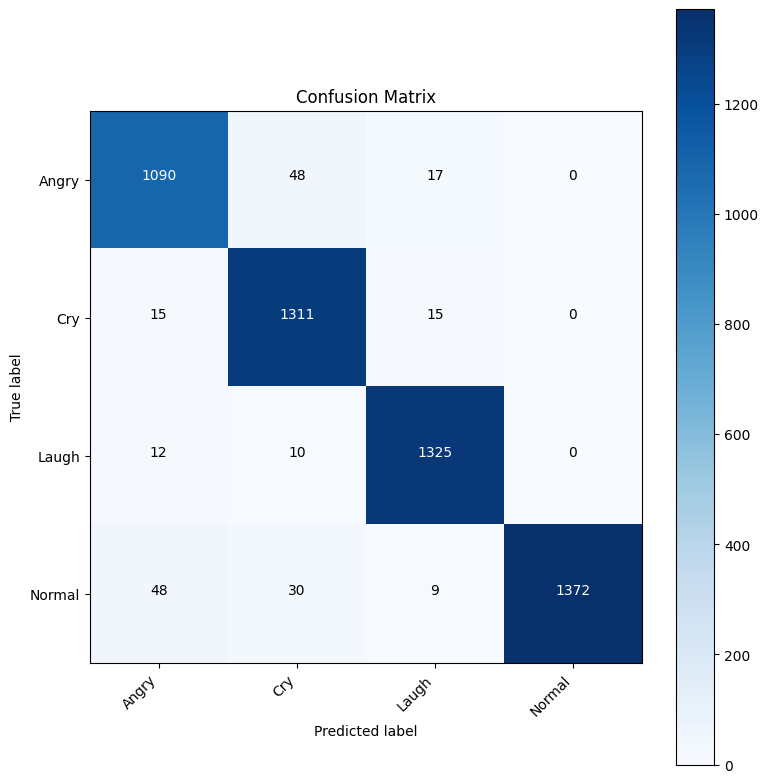

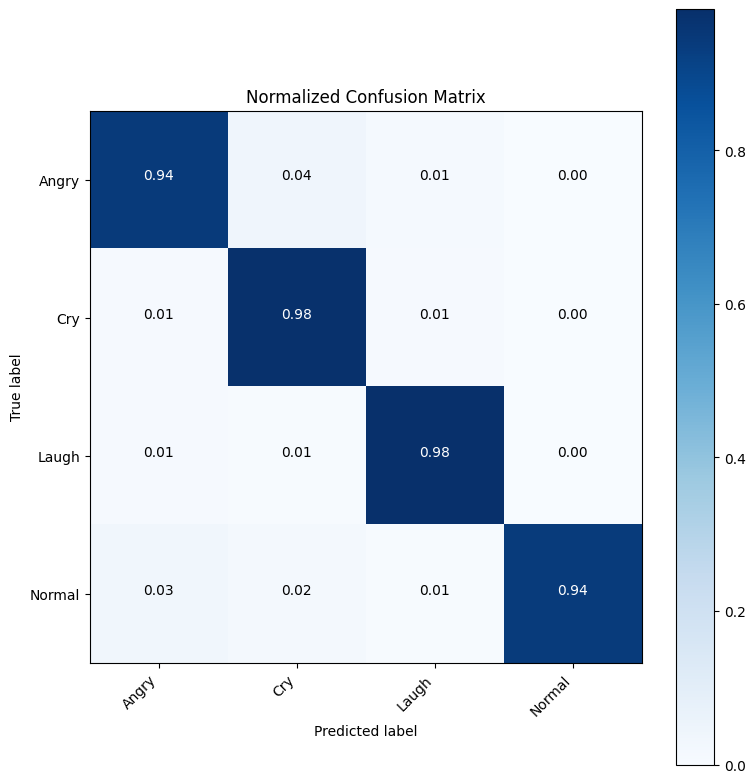


Classification report:

              precision    recall  f1-score   support

       Angry       0.94      0.94      0.94      1155
         Cry       0.94      0.98      0.96      1341
       Laugh       0.97      0.98      0.98      1347
      Normal       1.00      0.94      0.97      1459

    accuracy                           0.96      5302
   macro avg       0.96      0.96      0.96      5302
weighted avg       0.96      0.96      0.96      5302



In [6]:
# Cell 7: Evaluate final model + confusion matrix + classification report

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Load best fine-tuned model
final_model_path = phase2_best_path  # or phase2_final_path if you prefer
model = keras.models.load_model(final_model_path)
print("Loaded final model from:", final_model_path)

val_loss, val_acc, val_top3 = model.evaluate(val_ds, verbose=1)
print(f"\nValidation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")
print(f"Validation top-3 accuracy: {val_top3:.4f}")

# Collect preds and true labels
y_true = []
y_pred = []

for batch_imgs, batch_labels in val_ds:
    preds = model.predict(batch_imgs, verbose=0)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:\n", cm)

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix"):
    if normalize:
        cm_plot = cm.astype("float") / cm.sum(axis=1, keepdims=True)
        title = "Normalized Confusion Matrix"
    else:
        cm_plot = cm

    plt.figure(figsize=(8,8))
    plt.imshow(cm_plot, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm_plot.max() / 2.0
    for i, j in itertools.product(range(cm_plot.shape[0]), range(cm_plot.shape[1])):
        plt.text(
            j,
            i,
            format(cm_plot[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm_plot[i, j] > thresh else "black",
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, class_names, normalize=False)
plot_confusion_matrix(cm, class_names, normalize=True)

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


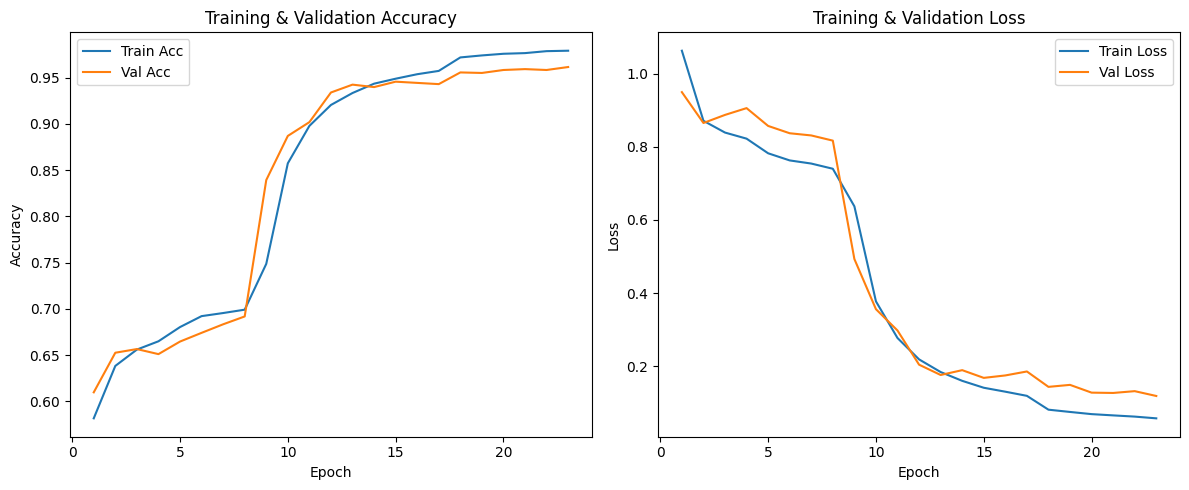

In [7]:
# Cell 8: Plot accuracy & loss across Phase 1 + Phase 2

def concat_histories(h1, h2):
    combined = {}
    for k in h1.history.keys():
        if k in h2.history:
            combined[k] = h1.history[k] + h2.history[k]
        else:
            combined[k] = h1.history[k]
    for k in h2.history.keys():
        if k not in combined:
            combined[k] = [None] * len(next(iter(h1.history.values()))) + h2.history[k]
    return combined

history_all = concat_histories(history_phase1, history_phase2)

acc = history_all["accuracy"]
val_acc = history_all["val_accuracy"]
loss = history_all["loss"]
val_loss = history_all["val_loss"]

epochs_all = range(1, len(acc) + 1)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_all, acc, label="Train Acc")
plt.plot(epochs_all, val_acc, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_all, loss, label="Train Loss")
plt.plot(epochs_all, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
# Cell 1: Load trained model + remember IMG_SIZE and class_names

from tensorflow import keras
import tensorflow as tf
import numpy as np

# Adjust this if your best model is saved somewhere else
BEST_MODEL_PATH = "checkpoints/b3_phase2_best.keras"

IMG_SIZE = (256, 256)  # same as training

model = keras.models.load_model(BEST_MODEL_PATH)
print("Loaded model from:", BEST_MODEL_PATH)

print("Classes:", class_names)  # must exist from dataset loading

Loaded model from: checkpoints/b3_phase2_best.keras
Classes: ['Angry', 'Cry', 'Laugh', 'Normal']


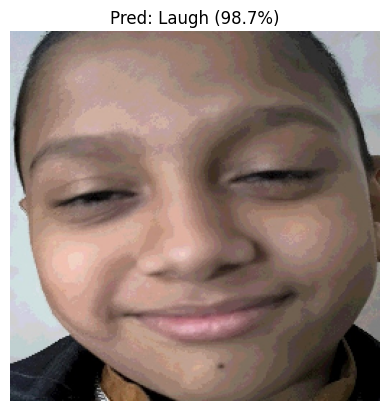

Prediction probabilities:
  Angry:   1.2%
    Cry:   0.0%
  Laugh:  98.7%
 Normal:   0.0%


('Laugh',
 0.9872184991836548,
 array([1.2301984e-02, 4.7950546e-04, 9.8721850e-01, 2.1151281e-09],
       dtype=float32))

In [21]:
# Cell 2: Helper function to predict on a single image path

import matplotlib.pyplot as plt
from pathlib import Path

def predict_image(image_path):
    image_path = Path(image_path)
    if not image_path.exists():
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Load & preprocess
    img = tf.keras.utils.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)  # shape (1, H, W, 3)

    # Predict
    preds = model.predict(img_batch, verbose=0)[0]  # shape (num_classes,)
    top_idx = np.argmax(preds)
    top_class = class_names[top_idx]
    top_conf = float(preds[top_idx])

    # Plot image + print probs
    plt.imshow(img.astype("uint8") if isinstance(img, np.ndarray) else img)
    plt.axis("off")
    plt.title(f"Pred: {top_class} ({top_conf*100:.1f}%)")
    plt.show()

    print("Prediction probabilities:")
    for i, cls in enumerate(class_names):
        print(f"{cls:>7}: {preds[i]*100:5.1f}%")

    return top_class, top_conf, preds

# Example (change to your image path)
predict_image("/mnt/d/ai-baby-care/dataset/Laugh/Laugh     (1)_aug_18.jpg")

FileUpload(value=(), accept='image/*', description='Upload')

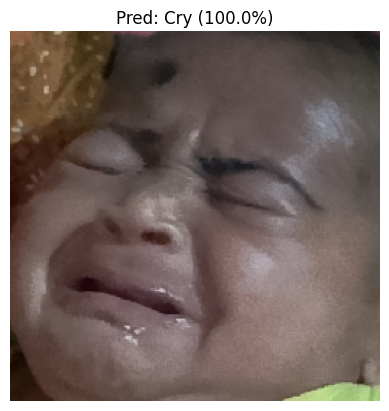

In [ ]:
# Cell 3: Upload image (VS Code compatible) + PNG/JPG support

import ipywidgets as widgets
from IPython.display import display
import tempfile
import os

upload_widget = widgets.FileUpload(
    accept="image/*",
    multiple=False
)

display(upload_widget)

def on_upload_change(change):
    value = upload_widget.value
    if not value:
        return

    # Always a tuple in VS Code
    info = value[0]

    # Extract info
    filename = info["name"]                  # e.g. "baby.png"
    content = info["content"]                # raw bytes

    # Extract extension
    _, ext = os.path.splitext(filename)
    if ext == "":
        ext = ".jpg"

    # Save to temp file
    tmp_file = tempfile.NamedTemporaryFile(delete=False, suffix=ext)
    tmp_file.write(content)
    tmp_file.flush()
    tmp_path = tmp_file.name
    tmp_file.close()

    print("\nSaved uploaded image to:", tmp_path)

    # Run prediction
    predict_image(tmp_path)

upload_widget.observe(on_upload_change, names="value")